## Import and Constants

In [0]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
#google colaboratory
from google.colab import drive
drive.mount('/content/gdrive')
BASE_DIR = '/content/gdrive/My Drive/Colab Notebooks/COGS118A_project/'

# directory
#BASE_DIR = '/Users/hiroshi/Desktop/COGS118A_project/'
dir_poker = BASE_DIR + 'poker_hand/poker_hand_training.data'
dir_cancer = BASE_DIR + 'breast_cancer/breast-cancer-wisconsin.data'
dir_wine = BASE_DIR + 'wine_quality/winequality_white.csv'

# constant
RATIO_OF_TRAIN = [0.2, 0.5, 0.8]
PERCENT = 100
C_LIST = [0.01, 0.1, 1.0, 2.0, 3.0]
MAX_DEPTH = [3,5, 10, 20, 30]
N_ESTIMATORS = [3,5, 10, 20, 30, 50]
N_NEIGHBORS = [3, 5, 10, 15]
WEIGHTS = ['uniform', 'distance']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Prediction Function

In [0]:
## Function for the prediction
def train_predict(X, Y):
    test_svm = []
    test_rfc = []
    test_knn = []
    score_svm = np.zeros((6,5))
    score_rfc = list()
    score_knn = list()
    
    for i, RATIO in enumerate(RATIO_OF_TRAIN):
        print(f'##### The ratio of training dataset for the following is {RATIO*PERCENT} % #####\n')
        
        # Set the training and testing dataset
        TRAIN_LENGTH = int(len(X)*RATIO)
        X_train = X[:TRAIN_LENGTH,:]
        X_test = X[TRAIN_LENGTH:,:]
        Y_train = Y[:TRAIN_LENGTH]
        Y_test = Y[TRAIN_LENGTH:]
        
        ### Cross Validation ###
        
        # SVM
        svc = SVC(kernel='linear')
        parameters_svc = {'C':C_LIST}
        clf_svc = GridSearchCV(svc, parameters_svc, cv=5, return_train_score=True)
        clf_svc.fit(X_train, Y_train)
        score_svm[i] = clf_svc.cv_results_['mean_train_score'] #(5,)
        score_svm[2*i+1] = clf_svc.cv_results_['mean_test_score'] #(5,)
        test = clf_svc.score(X_test, Y_test)
        test_svm.append(test)
        print('Train accuracy of SVM is: ', clf_svc.score(X_train, Y_train))
        print('Test accuracy of SVM is: ', test, '\n')
        
        # Random Forest Classifier
        rfc = RandomForestClassifier()
        parameters_rfc = {'n_estimators':N_ESTIMATORS, 'max_depth':MAX_DEPTH}
        clf_rfc = GridSearchCV(rfc, parameters_rfc, cv=5, return_train_score=True)
        clf_rfc.fit(X_train, Y_train)
        score_rfc.append(clf_rfc.cv_results_)
        test = clf_rfc.score(X_test, Y_test)
        test_rfc.append(test)
        print('Train accuracy of Random Forest Classifier is: ', clf_rfc.score(X_train, Y_train))
        print('Test accuracy of Random Forest Classifier is: ', test, '\n')

        # K-Nearest Neighbors
        knn =KNeighborsClassifier()
        parameters_knn = {'n_neighbors':N_NEIGHBORS, 'weights':WEIGHTS}
        clf_knn = GridSearchCV(knn, parameters_knn, cv=5, return_train_score=True)
        clf_knn.fit(X_train, Y_train)
        score_knn.append(clf_knn.cv_results_)
        test = clf_knn.score(X_test, Y_test)
        test_knn.append(test)
        print('Train accuracy of K-Nearest Neighbors is: ', clf_knn.score(X_train, Y_train))
        print('Test accuracy of K-Nearest Neighbors is: ', test, '\n')
    
    # End of loop
    print('### Test Results ###')
    print('The average test accuracy of SVM is :', sum(test_svm)/len(test_svm))
    print('The average test accuracy of Random Forest is :', sum(test_rfc)/len(test_rfc))
    print('The average test accuracy of K-Nearest Neighbors is :', sum(test_knn)/len(test_knn))
    
    return test_svm, test_rfc, test_knn, score_svm, score_rfc, score_knn

In [0]:
def draw_grid_search(err_svm, err_rfc, err_knn):
    
    # Show heatmap
    for i in range(0,len(err_svm),2):
        draw_heatmap_linear(err_svm[i].reshape(-1,1), 'train_accuracy', C_LIST)
        draw_heatmap_linear(err_svm[i+1].reshape(-1,1), 'validation_accuracy', C_LIST)
    
    # Show pandas dataframe
    for ratio, dict_rfc, dict_knn in zip(RATIO_OF_TRAIN, err_rfc, err_knn):
        print(f'########## Ratio of train:test is {int(ratio*100)}:{int(100 - ratio*100)} ##########')
        display(pd.DataFrame(dict_rfc).loc[:,['params','mean_train_score','mean_test_score']])
        display(pd.DataFrame(dict_knn).loc[:,['params','mean_train_score','mean_test_score']])
        
def draw_heatmap_linear(acc, acc_desc, C_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$C$')
    plt.title(acc_desc + ' w.r.t $C$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

## Breast Cancer Dataset

### Load and Set up Dataset

In [0]:
# Load breast cancer data
cancer_data = np.zeros((699,11),dtype=np.int8)
f = open(dir_cancer)
for i, row in enumerate(csv.reader(f)):
    cancer_data[i] = np.asarray(row, dtype=np.int8)
f.close()

# drop the id column
cancer_data = cancer_data[:,1:]

# separate into x and y dataset
X_cancer = cancer_data[:,:9]
Y_cancer = cancer_data[:,9]

### Prediction

In [12]:
# train and predict the cancer dataset
acc_svm, acc_rfc, acc_knn, err_svm, err_rfc, err_knn = train_predict(X_cancer, Y_cancer)

##### The ratio of training dataset for the following is 20.0 % #####

Train accuracy of SVM is:  0.9712230215827338
Test accuracy of SVM is:  0.9696428571428571 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train accuracy of Random Forest Classifier is:  0.9712230215827338
Test accuracy of Random Forest Classifier is:  0.9660714285714286 

Train accuracy of K-Nearest Neighbors is:  1.0
Test accuracy of K-Nearest Neighbors is:  0.9642857142857143 

##### The ratio of training dataset for the following is 50.0 % #####

Train accuracy of SVM is:  0.9570200573065902
Test accuracy of SVM is:  0.9828571428571429 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train accuracy of Random Forest Classifier is:  0.9627507163323782
Test accuracy of Random Forest Classifier is:  0.9742857142857143 

Train accuracy of K-Nearest Neighbors is:  0.9742120343839542
Test accuracy of K-Nearest Neighbors is:  0.9828571428571429 

##### The ratio of training dataset for the following is 80.0 % #####



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train accuracy of SVM is:  0.9660107334525939
Test accuracy of SVM is:  1.0 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train accuracy of Random Forest Classifier is:  0.9695885509838998
Test accuracy of Random Forest Classifier is:  0.9928571428571429 

Train accuracy of K-Nearest Neighbors is:  0.9767441860465116
Test accuracy of K-Nearest Neighbors is:  0.9785714285714285 

### Test Results ###
The average test accuracy of SVM is : 0.9841666666666667
The average test accuracy of Random Forest is : 0.9777380952380952
The average test accuracy of K-Nearest Neighbors is : 0.9752380952380952


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


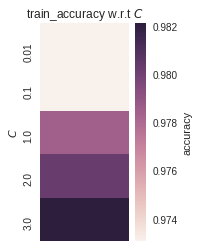

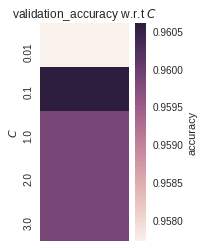

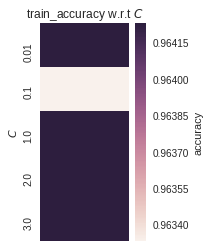

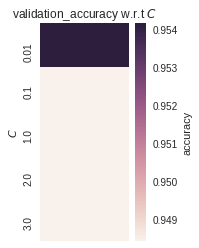

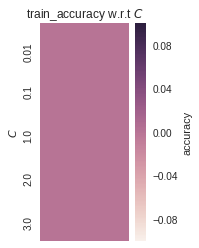

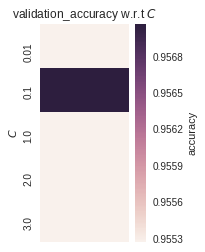

########## Ratio of train:test is 20:80 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.964026,0.942446
1,"{'max_depth': 3, 'n_estimators': 5}",0.974838,0.949640
2,"{'max_depth': 3, 'n_estimators': 10}",0.973084,0.949640
3,"{'max_depth': 3, 'n_estimators': 20}",0.976656,0.949640
4,"{'max_depth': 3, 'n_estimators': 30}",0.974870,0.956835
5,"{'max_depth': 3, 'n_estimators': 50}",0.978474,0.964029
6,"{'max_depth': 5, 'n_estimators': 3}",0.985617,0.892086
7,"{'max_depth': 5, 'n_estimators': 5}",0.989221,0.949640
8,"{'max_depth': 5, 'n_estimators': 10}",0.982143,0.920863
9,"{'max_depth': 5, 'n_estimators': 20}",0.992825,0.949640


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.976656,0.971223
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.971223
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.971266,0.971223
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.978417
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.951526,0.949640
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.956835
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.940682,0.935252
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.942446


########## Ratio of train:test is 50:50 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.963464,0.942693
1,"{'max_depth': 3, 'n_estimators': 5}",0.958466,0.936963
2,"{'max_depth': 3, 'n_estimators': 10}",0.967770,0.951289
3,"{'max_depth': 3, 'n_estimators': 20}",0.968484,0.957020
4,"{'max_depth': 3, 'n_estimators': 30}",0.967765,0.962751
5,"{'max_depth': 3, 'n_estimators': 50}",0.967770,0.954155
6,"{'max_depth': 5, 'n_estimators': 3}",0.978502,0.919771
7,"{'max_depth': 5, 'n_estimators': 5}",0.974920,0.936963
8,"{'max_depth': 5, 'n_estimators': 10}",0.978515,0.939828
9,"{'max_depth': 5, 'n_estimators': 20}",0.977798,0.951289


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.971341,0.948424
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.948424
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.965609,0.945559
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.945559
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.957726,0.939828
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.939828
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.952719,0.934097
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.934097


########## Ratio of train:test is 80:20 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.962884,0.948122
1,"{'max_depth': 3, 'n_estimators': 5}",0.963336,0.944544
2,"{'max_depth': 3, 'n_estimators': 10}",0.972277,0.955277
3,"{'max_depth': 3, 'n_estimators': 20}",0.973617,0.960644
4,"{'max_depth': 3, 'n_estimators': 30}",0.973618,0.957066
5,"{'max_depth': 3, 'n_estimators': 50}",0.973618,0.958855
6,"{'max_depth': 5, 'n_estimators': 3}",0.978538,0.935599
7,"{'max_depth': 5, 'n_estimators': 5}",0.977191,0.955277
8,"{'max_depth': 5, 'n_estimators': 10}",0.978540,0.955277
9,"{'max_depth': 5, 'n_estimators': 20}",0.980328,0.958855


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.976304,0.957066
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.957066
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.975855,0.955277
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.955277
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.961992,0.951699
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.953488
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.961992,0.953488
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.953488


In [13]:
draw_grid_search(err_svm, err_rfc, err_knn)

## Wine Quality Dataset

### Load and Set up Dataset

In [0]:
# load wine data
wine_data = np.zeros((4898,12),dtype=np.float16)
f = open(dir_wine)
line = f.readline()
i = 0
while(line):
    if i == 4897:
        data = np.asarray(line.split(';'), dtype=np.float16)
        wine_data[i] = data
        break
    data = np.asarray(line[:-1].split(';'), dtype=np.float16)
    wine_data[i] = data
    i += 1
    line = f.readline()
f.close()

# separate into x and y dataset
X_wine = wine_data[:,:11]
Y_wine = wine_data[:,11]

### Prediction

In [15]:
# train and predict the wine quality dataset
acc_svm, acc_rfc, acc_knn, err_svm, err_rfc, err_knn = train_predict(X_wine, Y_wine)

##### The ratio of training dataset for the following is 20.0 % #####



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train accuracy of SVM is:  0.5066394279877426
Test accuracy of SVM is:  0.4906863995917326 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, kee

Train accuracy of Random Forest Classifier is:  0.9519918283963228
Test accuracy of Random Forest Classifier is:  0.47078336310283236 



/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-pack

Train accuracy of K-Nearest Neighbors is:  1.0
Test accuracy of K-Nearest Neighbors is:  0.40137790252615463 

##### The ratio of training dataset for the following is 50.0 % #####

Train accuracy of SVM is:  0.5022458146182115
Test accuracy of SVM is:  0.5100040832993058 

Train accuracy of Random Forest Classifier is:  0.5933033891384238
Test accuracy of Random Forest Classifier is:  0.5304205798285014 



/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-pack

Train accuracy of K-Nearest Neighbors is:  0.5340955492037567
Test accuracy of K-Nearest Neighbors is:  0.4209881584320131 

##### The ratio of training dataset for the following is 80.0 % #####

Train accuracy of SVM is:  0.5066360387953037
Test accuracy of SVM is:  0.5948979591836735 

Train accuracy of Random Forest Classifier is:  0.5855028075548749
Test accuracy of Random Forest Classifier is:  0.5744897959183674 



/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-pack

Train accuracy of K-Nearest Neighbors is:  1.0
Test accuracy of K-Nearest Neighbors is:  0.4683673469387755 

### Test Results ###
The average test accuracy of SVM is : 0.5318628140249039
The average test accuracy of Random Forest is : 0.5252312462832337
The average test accuracy of K-Nearest Neighbors is : 0.4302444692989811


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-pack

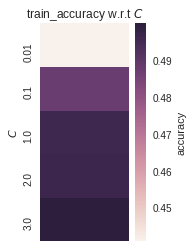

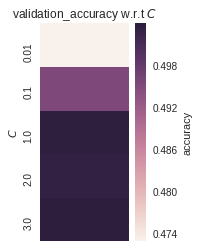

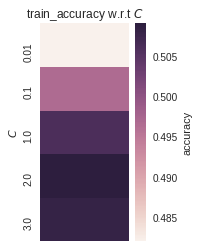

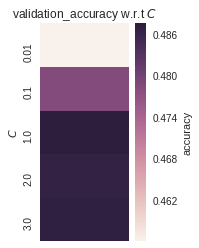

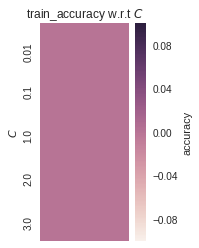

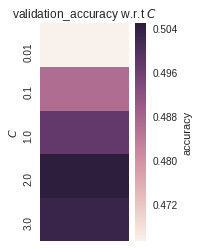

########## Ratio of train:test is 20:80 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.534704,0.454545
1,"{'max_depth': 3, 'n_estimators': 5}",0.556680,0.503575
2,"{'max_depth': 3, 'n_estimators': 10}",0.576091,0.489275
3,"{'max_depth': 3, 'n_estimators': 20}",0.589631,0.489275
4,"{'max_depth': 3, 'n_estimators': 30}",0.585029,0.478039
5,"{'max_depth': 3, 'n_estimators': 50}",0.593201,0.481103
6,"{'max_depth': 5, 'n_estimators': 3}",0.637650,0.452503
7,"{'max_depth': 5, 'n_estimators': 5}",0.657590,0.475996
8,"{'max_depth': 5, 'n_estimators': 10}",0.679536,0.498468
9,"{'max_depth': 5, 'n_estimators': 20}",0.705335,0.502554


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.726760,0.384065
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.371808
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.628705,0.404494
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.406537
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.566141,0.427988
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.422880
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.536028,0.433095
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.444331


########## Ratio of train:test is 50:50 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.516337,0.472846
1,"{'max_depth': 3, 'n_estimators': 5}",0.528081,0.477746
2,"{'max_depth': 3, 'n_estimators': 10}",0.535727,0.485096
3,"{'max_depth': 3, 'n_estimators': 20}",0.544097,0.494079
4,"{'max_depth': 3, 'n_estimators': 30}",0.544815,0.498979
5,"{'max_depth': 3, 'n_estimators': 50}",0.548489,0.489996
6,"{'max_depth': 5, 'n_estimators': 3}",0.582687,0.472846
7,"{'max_depth': 5, 'n_estimators': 5}",0.588609,0.485504
8,"{'max_depth': 5, 'n_estimators': 10}",0.601575,0.493671
9,"{'max_depth': 5, 'n_estimators': 20}",0.607895,0.501837


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.729383,0.362597
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.378522
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.638122,0.386280
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.390363
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.559716,0.401388
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.394855
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.529704,0.424663
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.417722


########## Ratio of train:test is 80:20 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.521630,0.492853
1,"{'max_depth': 3, 'n_estimators': 5}",0.533566,0.500255
2,"{'max_depth': 3, 'n_estimators': 10}",0.541350,0.513017
3,"{'max_depth': 3, 'n_estimators': 20}",0.545176,0.499234
4,"{'max_depth': 3, 'n_estimators': 30}",0.543901,0.511996
5,"{'max_depth': 3, 'n_estimators': 50}",0.543900,0.503573
6,"{'max_depth': 5, 'n_estimators': 3}",0.566362,0.493874
7,"{'max_depth': 5, 'n_estimators': 5}",0.578803,0.505615
8,"{'max_depth': 5, 'n_estimators': 10}",0.589398,0.504849
9,"{'max_depth': 5, 'n_estimators': 20}",0.597245,0.520929


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.745282,0.361409
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.379786
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.655948,0.385145
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.400715
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.565595,0.400715
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.404798
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.541602,0.402246
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.411434


In [16]:
draw_grid_search(err_svm, err_rfc, err_knn)

## Poker Dataset

### Load and Set up Dataset

In [0]:
# Load poker data
poker_data = np.zeros((25010,11), dtype=np.int8)

# Load poker data 1
f = open(dir_poker)
for i, row in enumerate(csv.reader(f)):
    poker_data[i] = np.asarray(row, dtype=np.int8)
f.close()

# Concatenate and shuffle the data
np.random.shuffle(poker_data)

# Divide into x and y dataset
X_poker = poker_data[:,:10]
Y_poker = poker_data[:,10]

In [18]:
# train and predict the poker dataset
acc_svm, acc_rfc, acc_knn, err_svm, err_rfc, err_knn = train_predict(X_poker, Y_poker)

##### The ratio of training dataset for the following is 20.0 % #####



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of SVM is:  0.4996001599360256
Test accuracy of SVM is:  0.499500199920032 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of Random Forest Classifier is:  0.9998000799680128
Test accuracy of Random Forest Classifier is:  0.5478308676529389 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of K-Nearest Neighbors is:  0.6377449020391843
Test accuracy of K-Nearest Neighbors is:  0.5442323070771692 

##### The ratio of training dataset for the following is 50.0 % #####



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of SVM is:  0.4946021591363455
Test accuracy of SVM is:  0.5044382247101159 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of Random Forest Classifier is:  0.7976809276289484
Test accuracy of Random Forest Classifier is:  0.5872051179528188 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of K-Nearest Neighbors is:  1.0
Test accuracy of K-Nearest Neighbors is:  0.568812475009996 

##### The ratio of training dataset for the following is 80.0 % #####



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of SVM is:  0.49810075969612155
Test accuracy of SVM is:  0.5051979208316674 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of Random Forest Classifier is:  0.9999500199920032
Test accuracy of Random Forest Classifier is:  0.5985605757696921 



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Train accuracy of K-Nearest Neighbors is:  1.0
Test accuracy of K-Nearest Neighbors is:  0.5757696921231508 

### Test Results ###
The average test accuracy of SVM is : 0.5030454484872718
The average test accuracy of Random Forest is : 0.5778655204584833
The average test accuracy of K-Nearest Neighbors is : 0.5629381580701053


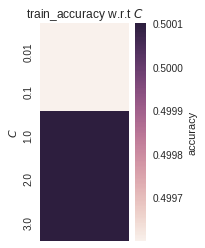

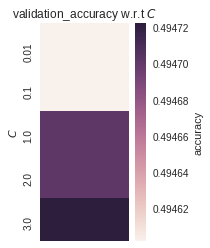

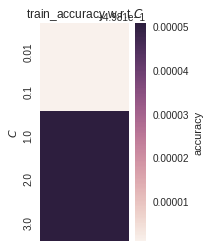

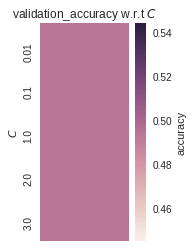

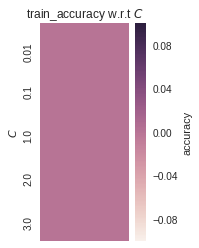

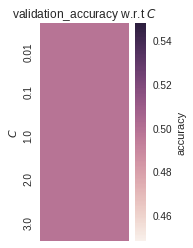

########## Ratio of train:test is 20:80 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.522041,0.507797
1,"{'max_depth': 3, 'n_estimators': 5}",0.527139,0.505398
2,"{'max_depth': 3, 'n_estimators': 10}",0.524091,0.509796
3,"{'max_depth': 3, 'n_estimators': 20}",0.522991,0.505198
4,"{'max_depth': 3, 'n_estimators': 30}",0.521591,0.509196
5,"{'max_depth': 3, 'n_estimators': 50}",0.517545,0.507597
6,"{'max_depth': 5, 'n_estimators': 3}",0.561229,0.505798
7,"{'max_depth': 5, 'n_estimators': 5}",0.571170,0.515194
8,"{'max_depth': 5, 'n_estimators': 10}",0.588817,0.528389
9,"{'max_depth': 5, 'n_estimators': 20}",0.591166,0.534386


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.731806,0.521591
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.513994
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.678578,0.528389
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.529588
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.634148,0.543583
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.539784
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.615605,0.542383
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.542783


########## Ratio of train:test is 50:50 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.508276,0.500120
1,"{'max_depth': 3, 'n_estimators': 5}",0.517392,0.513794
2,"{'max_depth': 3, 'n_estimators': 10}",0.515913,0.512435
3,"{'max_depth': 3, 'n_estimators': 20}",0.509937,0.509076
4,"{'max_depth': 3, 'n_estimators': 30}",0.505818,0.503399
5,"{'max_depth': 3, 'n_estimators': 50}",0.504158,0.502439
6,"{'max_depth': 5, 'n_estimators': 3}",0.544083,0.521391
7,"{'max_depth': 5, 'n_estimators': 5}",0.555158,0.528189
8,"{'max_depth': 5, 'n_estimators': 10}",0.564152,0.537785
9,"{'max_depth': 5, 'n_estimators': 20}",0.565253,0.540504


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.742064,0.531707
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.527389
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.689924,0.542023
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.541623
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.646522,0.562015
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.558017
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.633147,0.558737
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.562735


########## Ratio of train:test is 80:20 ##########


,params,mean_train_score,mean_test_score
0,"{'max_depth': 3, 'n_estimators': 3}",0.514619,0.514044
1,"{'max_depth': 3, 'n_estimators': 5}",0.509447,0.507247
2,"{'max_depth': 3, 'n_estimators': 10}",0.508421,0.506248
3,"{'max_depth': 3, 'n_estimators': 20}",0.507535,0.505148
4,"{'max_depth': 3, 'n_estimators': 30}",0.503786,0.502649
5,"{'max_depth': 3, 'n_estimators': 50}",0.502361,0.502399
6,"{'max_depth': 5, 'n_estimators': 3}",0.543208,0.531337
7,"{'max_depth': 5, 'n_estimators': 5}",0.550355,0.533287
8,"{'max_depth': 5, 'n_estimators': 10}",0.552030,0.537785
9,"{'max_depth': 5, 'n_estimators': 20}",0.556777,0.545882


,params,mean_train_score,mean_test_score
0,"{'n_neighbors': 3, 'weights': 'uniform'}",0.741365,0.529938
1,"{'n_neighbors': 3, 'weights': 'distance'}",1.000000,0.526589
2,"{'n_neighbors': 5, 'weights': 'uniform'}",0.690524,0.540084
3,"{'n_neighbors': 5, 'weights': 'distance'}",1.000000,0.542583
4,"{'n_neighbors': 10, 'weights': 'uniform'}",0.647916,0.566773
5,"{'n_neighbors': 10, 'weights': 'distance'}",1.000000,0.561925
6,"{'n_neighbors': 15, 'weights': 'uniform'}",0.632872,0.569072
7,"{'n_neighbors': 15, 'weights': 'distance'}",1.000000,0.570272


In [19]:
draw_grid_search(err_svm, err_rfc, err_knn)